## Content

* ### [Introduction](#introduction)
    * #### [Data Management](#data-mgmt)
* ### [Feature Engineering](#feature-eng)
    * #### [Normalizing data](#normalizing)
* ### [Feature Selection](#feature-sel)
    * #### [Correlation with target variable](#corr-target)
    * #### [Reducing multicollinearity](#reduce-col)
    * #### [Correlation over time](#cor-time)
* ### [Modelling](#modelling)
* ### [Model Evaluation](#model-eval)
* ### [Conclusion](#conclusion)
    * #### [Suggestions for Future Research](#suggestions)
* ### [References](#references)

# Introduction <a name="introduction"></a>

Predicting the stock market has always been an attractive topic, mainly because of its vitality in the economic and ﬁnancial sectors. As long as markets have
existed, investors have searched for ways to acquire knowledge about the
companies listed in the market to improve their investment returns. Yet, predictions of the stock market pose a challenging exercise, even to the brightest and sharpest minds in the business. Prediction of stock market is never an easy task, due to the complexity and dynamic characteristics of the data it deals with. 

There are several unique challenges present in this domain that are not present in other common areas of machine learning such as Natural Language Processing, spam detection, computer vision and others. These challenges include:
* Swithing of regimes (non-stationarity)
* Reflexivity (market adaptation)
* Low signal-to-noise ratio

In this project, I tried to predict the next day's change in price of an asset using only historical data and technical indicators.


Let's strart by importing the libraries libraries

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import technical_indicator as ti
import plotting as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler,Normalizer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import datetime as dt

## Data Management <a name="data-mgmt"></a>

**`features`**

Contains all features to be used for prediction. To avoid look-ahead bias, the dataframe only contains values that would have been known at that point in time. I'll explain about look-ahead bias later.

**`outcomes`**

Contains all possible outcomes to be predicted, conviniently shifted back in time. For example, if we wanted to predict the next day return, we would look ahead one day into the future, calculate the metric and record it at time T=0.

This makes it very easy to extract X and y for fitting models and join both dataframes as the rows are already aligned. 

Let's start from downloading the dataset. I used yfinance package to download prices.

Note: Set auto_adjust parameter to True so that the prices are adjusted for splits and dividends. 


In [2]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'SPY']
df = yf.download(tickers, period='10y', auto_adjust=True, group_by='ticker')
df.head(200)

[*********************100%***********************]  4 of 4 completed


AAPL                                                     SPY  \
                 Open       High        Low      Close     Volume        Open   
Date                                                                            
2011-03-31  10.655063  10.760888  10.645835  10.721204  274019200  108.783366   
2011-04-01  10.801189  10.815955  10.560929  10.599690  418661600  109.447882   
2011-04-04  10.592002  10.600923  10.410193  10.496021  460084800  109.464271   
2011-04-05  10.366819  10.528632  10.336363  10.425268  482731200  109.111513   
2011-04-06  10.496944  10.579389  10.371431  10.399117  402539200  109.833456   
...               ...        ...        ...        ...        ...         ...   
2012-01-09  13.089651  13.158867  12.961984  12.973674  394024400  106.748919   
2012-01-10  13.102258  13.105027  12.966593  13.020121  258196400  107.908144   
2012-01-11  13.002897  13.008128  12.899227  12.998899  215084800  107.357710   
2012-01-12  12.990590  13.009663  12.881997  12.963211  212587200  108.058251   
2012-01-13  12.911224  12.934296  12.879230  12.914607  226021600  107.282647   

                                                                MSFT  \
                  High         Low       Close     Volume       Open   
Date                                                                   
2011-03-31  109.078706  108.660300  108.775154  132537100  20.427046   
2011-04-01  109.743222  108.972056  109.234573  153850100  20.371196   
2011-04-04  109.661168  109.013068  109.324806  100768900  20.307352   
2011-04-05  109.792436  109.062292  109.308411  120791500  20.602593   
2011-04-06  109.931898  109.209953  109.652969  120411600  20.730259   
...                ...         ...         ...        ...        ...   
2012-01-09  106.899029  106.256876  106.765602   99530200  22.841583   
2012-01-10  108.124973  107.541192  107.691315  115282000  22.743872   
2012-01-11  107.891454  107.182582  107.749680  111540700  22.336710   
2012-01-12  108.166659  107.199244  108.008202  118983700  22.695014   
2012-01-13  107.624581  106.515391  107.449440  179836200  22.743871   

                                                             AMZN              \
                 High        Low      Close    Volume        Open        High   
Date                                                                            
2011-03-31  20.490880  20.219584  20.259480  63233700  179.309998  181.570007   
2011-04-01  20.371196  20.195650  20.331299  63114200  181.580002  183.250000   
2011-04-04  20.474917  20.275434  20.387144  35433700  180.889999  183.610001   
2011-04-05  20.889849  20.538759  20.570677  73651100  182.100006  186.360001   
2011-04-06  20.993577  20.634508  20.865908  65581400  186.149994  188.270004   
...               ...        ...        ...       ...         ...         ...   
2012-01-09  22.882300  22.572859  22.589146  59706800  182.759995  184.369995   
2012-01-10  22.923022  22.597295  22.670584  60014400  181.100006  182.399994   
2012-01-11  22.784583  22.287851  22.572861  65582400  179.639999  180.770004   
2012-01-12  22.817161  22.515863  22.800875  49370800  179.419998  179.490005   
2012-01-13  23.004452  22.629867  23.004452  60196100  175.809998  178.800003   

                                             
                   Low       Close   Volume  
Date                                         
2011-03-31  178.500000  180.130005  4826500  
2011-04-01  178.589996  180.130005  5684100  
2011-04-04  180.690002  182.940002  4186400  
2011-04-05  181.800003  185.289993  5569200  
2011-04-06  181.119995  182.759995  5430700  
...                ...         ...      ...  
2012-01-09  177.000000  178.559998  5056900  
2012-01-10  177.100006  179.339996  3985800  
2012-01-11  178.190002  178.899994  3102700  
2012-01-12  175.750000  175.929993  5385800  
2012-01-13  173.500000  178.419998  4753500  

[200 rows x 20 columns]

Visualising the datasets. I applied log function because Amazon stock were significantly higher, so it is impossible to visualise the prices of all three stocks

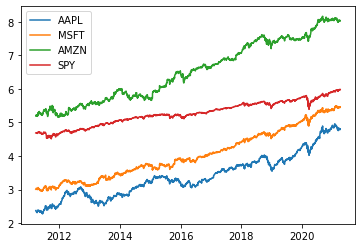

In [3]:
for ticker in tickers:
    plt.plot(df[ticker]['Close'].apply(np.log), label=ticker)
    
plt.legend()
    

# Feature Engineering <a name="feature-eng"></a>

Feature Engineering refers to pre-processing of raw data into a format which is more easily understood by machine learning algorithms. 

I believe it is one of the most important and underappreciated activities in machine learning. 


**Important considerations**

Since we are dealing with time-series data, it is crucial to be aware of potential challenges and biases we may introduce, whether intentially or unintentially.

**`Look-ahead bias`**

Look-ahead bias occurs when the information or data that is not available in the analysis period is used for a simulation. This can lead to innacurate results which are often overoptimistic. 

**`False ordinality`**

We should also avoid representing features in ordinal way if it has no meaning. For example, it is not the best approach to represent day of a week as an integer from 1 to 7 because we will be telling the model to treat one day differently than the other.



### Features to be considered:
`1`. Moving Averages

Moving average is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. Variations include: simple, and cumulative, or weighted forms. 
We'll be using simple and exponential moving averages as features and also to construct other features.

`2`. Daily return

Percent change between closing price and opening price

`3`. Log volume

Volume transformed to log scale.

`4`. Price difference

Difference between today's and yesterday's closing price

`5`. Relative Strength Index

Measures the magnitude of recent price changes. Commonly used in technical analysis to evaluate overbought or oversold conditions in the price of a stock.
This indicator was developed by J.Welles Wilder Jr.
According to this indicator, a stock is considered overbought when the RSI is above 70% and oversold when it is below 30%.

`6`. Stochastic Oscillator

The Stochastic Oscillator is a momentum indicator that compares a specific closing price of a security to its high-low range over a certain period of time. First developed in the 1950s, it is a popular momentum indicator to identify overbought and oversold conditions of an asset. 

`7`. Moving Average Convergence Divergence (MACD)
MACD is a trend-following momentum indicator that demonstrates the relationship between two moving averages - long-term and short-term. MACD is calculated as 

MACD = EMA(26-period) - EMA(12-period)

MACD is often used together with Relative Strength (RSI) to show a more complete picture of a market.

The signal line is a 9-day EMA of the MACD Line. As a moving average of the indicator, it trails the MACD and makes it easier to spot MACD turns.


`8`. Average True Range(ATR)

ATR is a market volatility indicator. Introduced by market technician J.Welles Wilder Jr., this indicator measures market volatility by decomposing the complete range of a security price for that period.


`9`. Accumulation/Distribution Indicator (A/D)

The accumulation/distribution indicator (A/D) is a cumulative indicator that makes us of price and volume to assess whether an asset is being accumulated or distributed.

`10`. Money Flow Index

The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.



### Target variable

We will be prediciting the next day's change in price.


In [4]:
feature_names = ['daily_return', 'price_diff', 'vol_log']
col_names = pd.MultiIndex.from_product([tickers, feature_names])
features = pd.DataFrame(index=df.index, columns=col_names).sort_index()

for ticker in tickers:
    features.loc[:, (ticker, 'daily_return')] = df[ticker]['Close'] / df[ticker]['Open'] - 1
    features.loc[:, (ticker, 'price_diff')] = df[ticker]['Close'].diff(1)
    features.loc[:, (ticker, 'vol_log')] = df[ticker]['Volume'].apply(np.log)
    features.loc[:, (ticker, 'vol_diff_1')] = df[ticker]['Volume'].diff(1)
    features.loc[:, (ticker, 'vol_diff_50')] = df[ticker]['Volume'].diff(50)
    
    # Rate of change in volume
    features.loc[:, (ticker, 'roc_vol')] = ti.rate_of_change(df[ticker]['Volume'])
    
    for period in [5, 10, 20, 50, 100, 200]:
        
        # Moving average of volume (log)
        features.loc[:, (ticker, 'sma{}_vol'.format(period))] = ti.simple_ma(features[ticker]['vol_log'], period=period)
        
        # Closing price vs n-day EMA 
        features.loc[:, (ticker, 'close_vs_ema{}'.format(period))] = df[ticker]['Close'] / ti.exp_ma(df[ticker]['Close'], period=period) - 1
         
        # Daily Volume vs. n-day SMA
        features.loc[:, (ticker, 'vol_vs_sma{}'.format(period))] = df[ticker]['Volume'] / ti.simple_ma(df[ticker]['Volume'], period=period) - 1
    
    # Average True Range (14-day)
    features.loc[:, (ticker, 'atr')] = ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])
    
    # High divided by Average True Range with window of 10
    features.loc[:, (ticker, 'high10atr')] = df[ticker]['High'] / ti.average_true_range(df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'], period=10)
       
    # Relative Strengh Index (RSI)
    features.loc[:, (ticker, 'RSI')] = ti.RSI(df[ticker]['Close'])
    
    # Money Flow Index (MFI)
    features.loc[:, (ticker, 'MFI')] = ti.money_flow_index(df[ticker]['Volume'], df[ticker]['High'], df[ticker]['Low'], df[ticker]['Close'])

    # Stochastic Oscillator
    features.loc[:, (ticker, 'STOCH')] = ti.stochastic_oscillator(df[ticker]['Close'], df[ticker]['High'], df[ticker]['Low'])
    
    # Moving Average Convergence Divergence (MACD)
    features.loc[:, (ticker, 'MACD')] = ti.MACD(df[ticker]['Close']).iloc[:, 0]
    features.loc[:, (ticker, 'MACD_signal')] = ti.MACD(df[ticker]['Close']).iloc[:, 1]

    # Accumulation/Distribution
    features.loc[:, (ticker, 'ADI')] = ti.accumulation_distribution(df[ticker]['Close'], df[ticker]['Low'], df[ticker]['High'], df[ticker]['Volume'])

outcome_names = ['target_close_1']
col_names_out = pd.MultiIndex.from_product([tickers, outcome_names])
outcomes = pd.DataFrame(index=df.index, columns=col_names_out).sort_index()

for ticker in tickers:
    # Change in closing price in the next day
    outcomes.loc[:, (ticker, 'target_close_1')] = df[ticker]['Close'].pct_change(-1)

In [5]:
df_new = features.join(outcomes)
df_new = df_new.dropna()

# Feature Selection <a name="feature-sel"></a>

In feature selection process, we aim to meet two objectives:

*Strength*: Choose the features with the strongest, most persistent relationships to the target outcome variable. The reasons for this are obvious.

*Reduce collinearity between features*: Minimize the amount of or collinearity in our selected features. 

### Normalizing data <a name="normalizing"></a>

Before diving into evaluation of the features for predictive strength, we will standardize data given that we have data of different scales.

For that, we can use StandardScaler() method as part of scikit-learn package.

In [6]:
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, index=df.index)
df_scaled.columns = df.columns


### Correlation with target variable <a name="corr-target"></a>

For simplicity purposes, going forward we will only consider the price of ETF S&P 500

<AxesSubplot:title={'center':'Strength of Correlation'}>

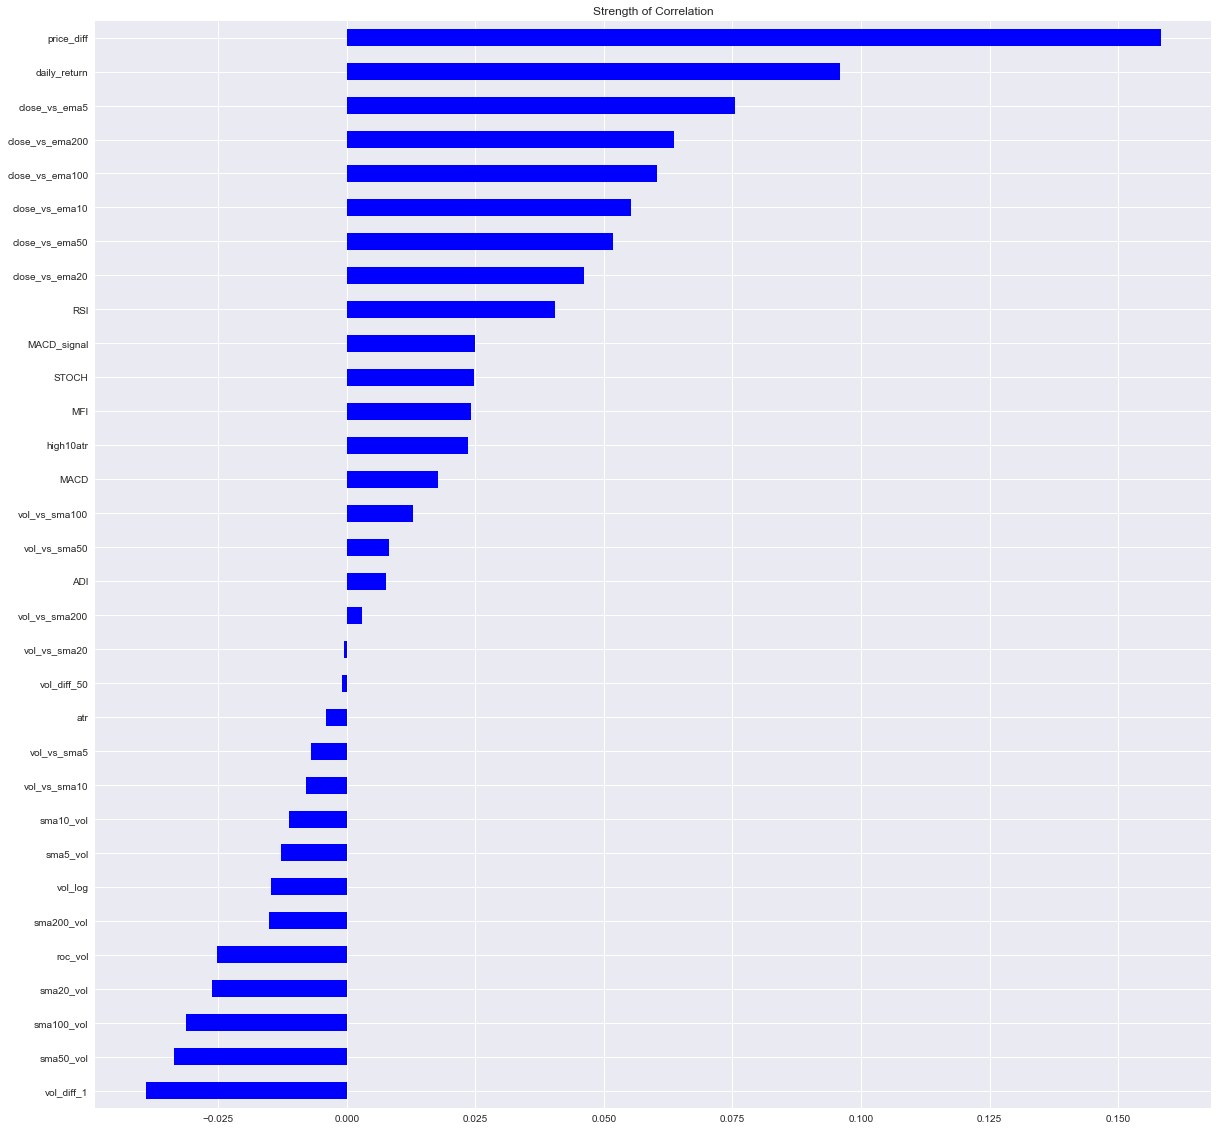

In [7]:
# Correlation strength
plt.style.use('seaborn')
plt.figure(figsize=(20,20))

corr = features['SPY'].corrwith(df_new['SPY']['target_close_1'])
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')


For simplicity purposes, going forward we will only consider the price of ETF S&P 500

Even though correlation is not the ideal metric, it should give us an idea of strengh of each feature's relationship to the target variable.

However, it gives us no information about multicollinearity. 

We can leverage seaborn's clustermap chart that plots a heatmap representation of a covariance matrix.

It is important to note that scaling the features before runtime is a form of data leakage (I mentioned look-ahead bias earlier). However, for the purpose of EDA and to understand better the feature set, it can be justified.
Of course, we will not be using these scaled features when it comes to model training and testing as this would not have been available at the time.



In [8]:
feats_max_corr = corr[corr > 0.02].index
corr.sort_values(ascending=False)

price_diff         0.158280
daily_return       0.095908
close_vs_ema5      0.075561
close_vs_ema200    0.063604
close_vs_ema100    0.060253
close_vs_ema10     0.055361
close_vs_ema50     0.051757
close_vs_ema20     0.046183
RSI                0.040551
MACD_signal        0.024914
STOCH              0.024739
MFI                0.024094
high10atr          0.023524
MACD               0.017770
vol_vs_sma100      0.012859
vol_vs_sma50       0.008126
ADI                0.007533
vol_vs_sma200      0.002873
vol_vs_sma20      -0.000620
vol_diff_50       -0.001030
atr               -0.004069
vol_vs_sma5       -0.006970
vol_vs_sma10      -0.007966
sma10_vol         -0.011184
sma5_vol          -0.012726
vol_log           -0.014791
sma200_vol        -0.015118
roc_vol           -0.025290
sma20_vol         -0.026135
sma100_vol        -0.031221
sma50_vol         -0.033601
vol_diff_1        -0.039018
dtype: float64

## Reducing multicollinearity <a name="reduce-col"></a>

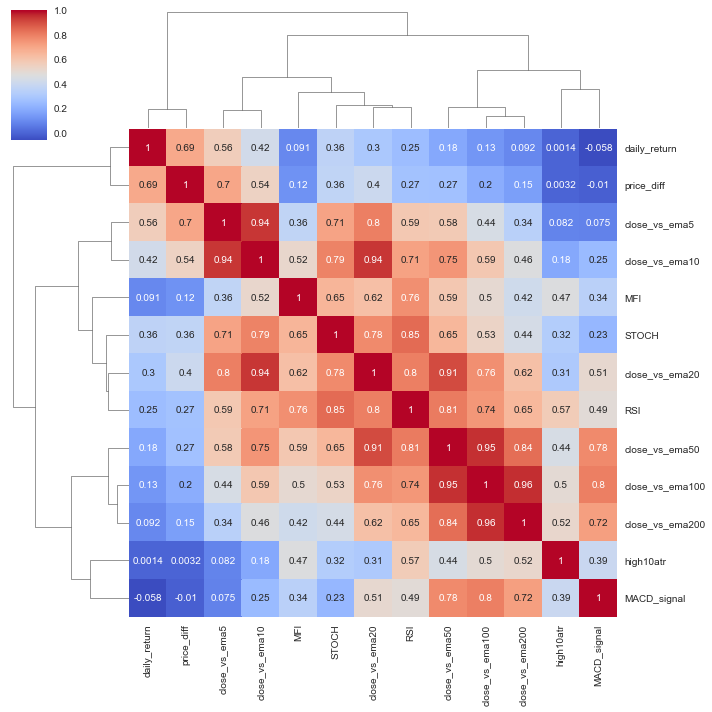

In [9]:
sns.clustermap(features['SPY'][feats_max_corr].corr(), cmap='coolwarm', annot=True, method='ward')

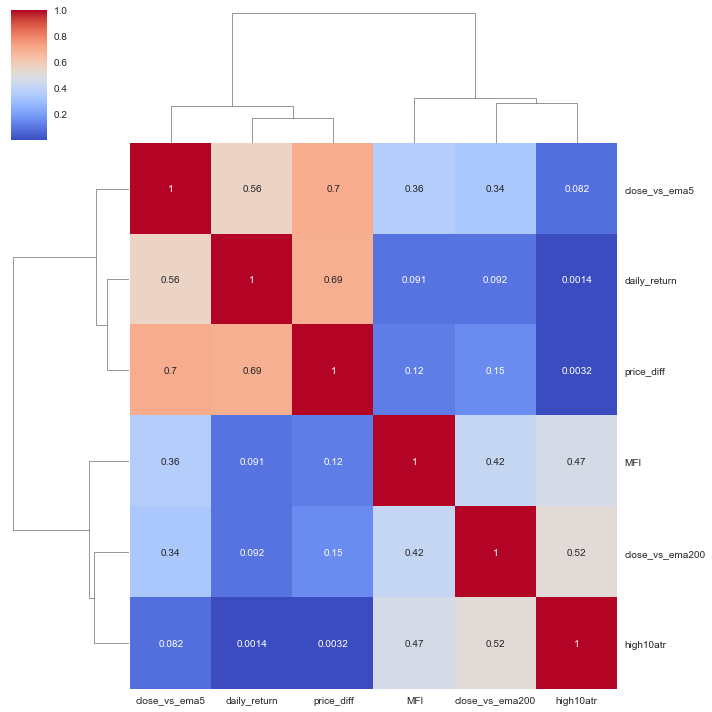

In [10]:
feats_selected = feats_max_corr.drop(['close_vs_ema10', 'close_vs_ema100', 
                                      'close_vs_ema20', 'RSI', 'close_vs_ema50', 
                                      'MACD_signal', 'STOCH'])
sns.clustermap(features['SPY'][feats_selected].corr(), cmap='coolwarm', annot=True, method='ward')


In [11]:
features_selected = df_new['SPY'][feats_selected]
df_SPY = df_new['SPY'].loc[:, features_selected.columns]

df_SPY = df_SPY.join(df_new['SPY']['target_close_1'])
df_SPY

,daily_return,price_diff,close_vs_ema5,close_vs_ema200,high10atr,MFI,target_close_1
Date,,,,,,,
2012-01-13,0.001555,-0.558762,0.000185,0.043232,93.923072,69.834158,-0.003866
2012-01-17,-0.005689,0.416977,0.002707,0.046712,90.563113,70.546197,-0.010935
2012-01-18,0.011291,1.192604,0.009153,0.057577,98.598702,71.803731,-0.005249
2012-01-19,0.001829,0.575462,0.009606,0.062389,101.441996,78.085839,-0.003713
2012-01-20,0.005410,0.408638,0.008873,0.065540,108.155932,78.321270,0.002583
...,...,...,...,...,...,...,...
2021-03-24,-0.008900,-1.980011,-0.006017,0.095844,83.886563,58.167518,-0.005594
2021-03-25,0.009638,2.180023,-0.000283,0.100892,82.361506,48.545914,-0.015859
2021-03-26,0.012918,6.279999,0.010496,0.117313,77.531595,48.303066,0.000505


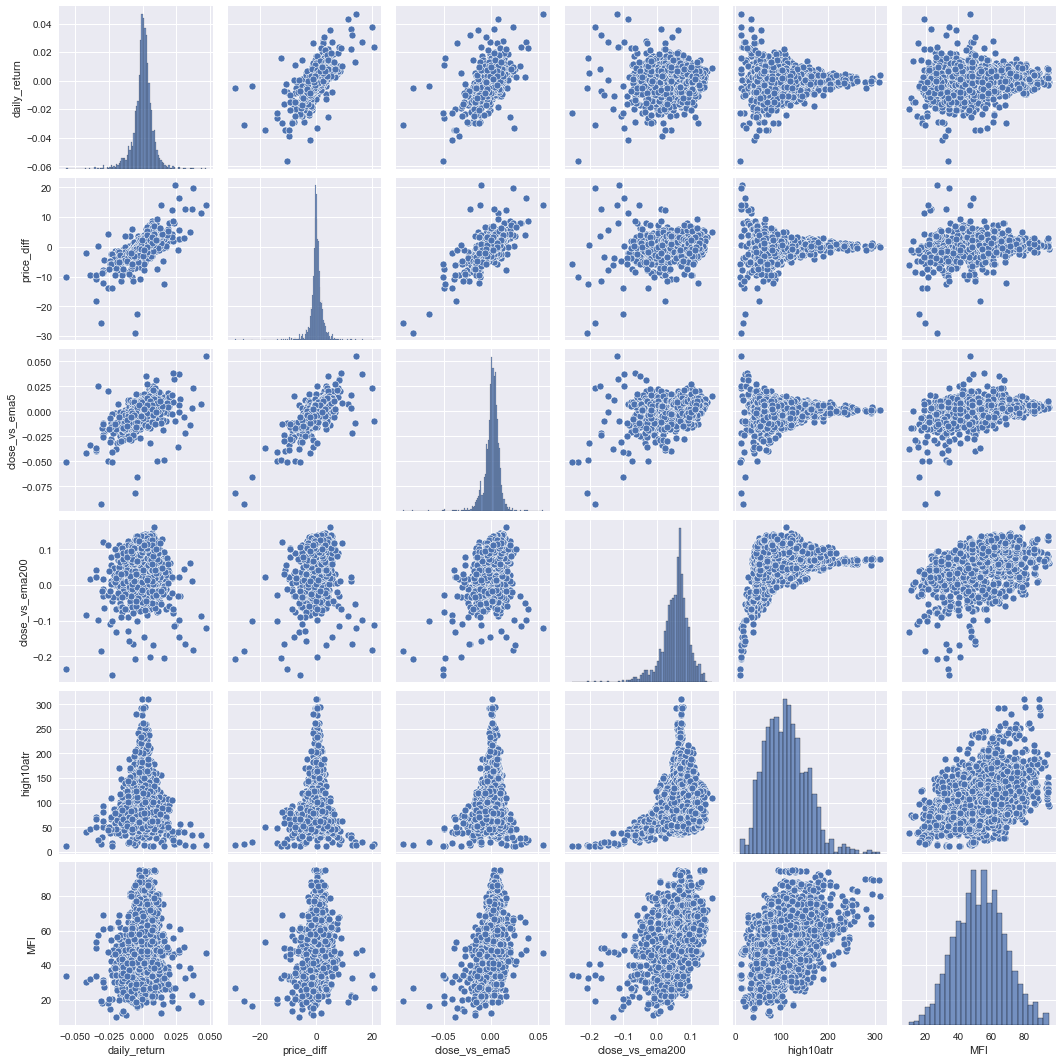

In [12]:
sns.pairplot(features_selected)

There is still some residual covariance, but we're close.


So far, I have only used a simple correlation statistic on a full range of data thus far, but we shouldn't stop here.

### Correlation over time<a name="cor-time"></a>

Given that we're working with financial time series which is non-stationary and subject to constant regime change, the relationship that has been in place on average may be very unstable over time.

Below I'm plotting the rolling correlation of the selected features

<AxesSubplot:title={'center':'Correlation of features with target (by month)'}, xlabel='Date'>

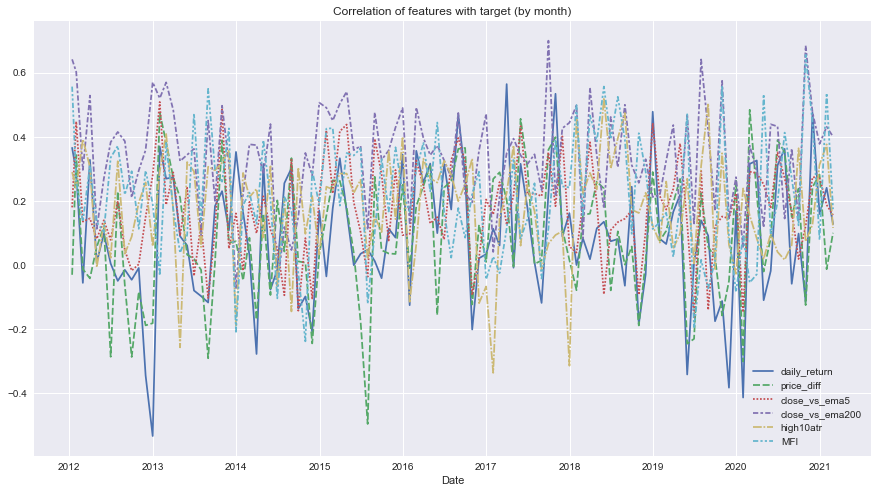

In [13]:
recalc_dates = df_SPY.resample('M').mean().index # Resample by month
recalc_dates = recalc_dates.insert(item=min(df_SPY.index), loc=0) # Add starting date
corrs = pd.DataFrame(index=recalc_dates, columns=features_selected.columns)
for i, date in enumerate(recalc_dates):
    try:
        corr = features_selected.loc[recalc_dates[i]:recalc_dates[i+1]].corrwith(df_SPY.loc[recalc_dates[i]:recalc_dates[i+1]]['target_close_1'])
        corrs.loc[date, :] = corr

    except:
        break

corrs = corrs.dropna()
corrs = corrs.apply(lambda x: x.astype(float))

plt.figure(figsize=(15,8))
plt.title('Correlation of features with target (by month)')
sns.lineplot(data=corrs)


This figure shows us that the correlation of features with the target variable are not consistent. In fact, most features are oscillating between positive and negative values. This may result in a poor fit when modelling with Linear Regression.

# Modelling<a name="modelling"></a>

### Splitting data and re-scaling

#### Simple splitting (80/20)

Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


In [14]:
split_point = int(0.80*len(df))

train_dataset = features_selected.join(df_SPY['target_close_1']).iloc[:split_point,:]

X_train = train_dataset.iloc[:,:-1]
y_train = train_dataset['target_close_1']

X_test = features_selected.iloc[split_point:,:] 
y_test = df_SPY['target_close_1'].iloc[split_point:]

# Transform training dataset
X_train = standard_scaler.fit_transform(X_train)
y_train = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))


# Transform test dataset
X_test = standard_scaler.fit_transform(X_test)
y_test = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))


### Linear Regression

We'll start from simple linear regression

R2 in-sample: 0.006809768458464482
R2 out-of-sample: -0.002607993915938245
Regression Coefficients: [[ 0.06118629 -0.05643082  0.02235009  0.06191689 -0.00963402  0.01121625]]


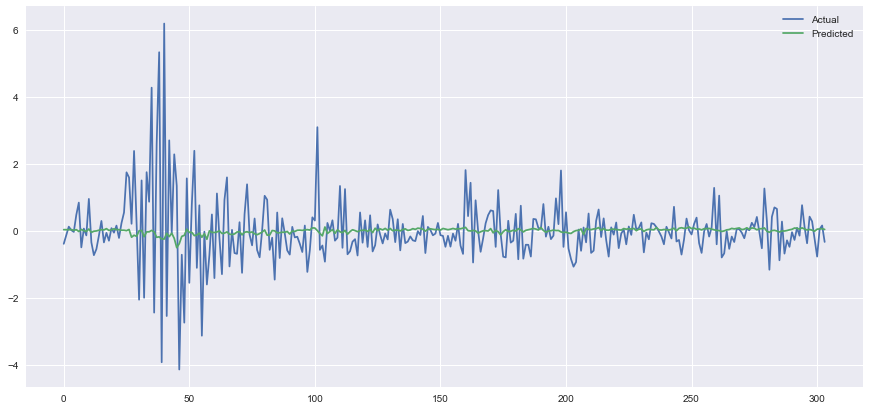

In [15]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)

print('R2 in-sample: {}'.format(model.score(X=X_train, y=y_train)))
print('R2 out-of-sample: {}'.format(model.score(X=X_test, y=y_test)))
print('Regression Coefficients: {}'.format(model.coef_))

lr_pred = model.predict(X_test)

plt.figure(figsize=(15,7))
plt.plot(y_test, label='Actual')
plt.plot(lr_pred, label='Predicted')
plt.legend()
plt.show()

### XGBoost Regressor
XGBoost is a powerful approach for building supervised regression models.

R2 out-of-sample -0.2057783330616445


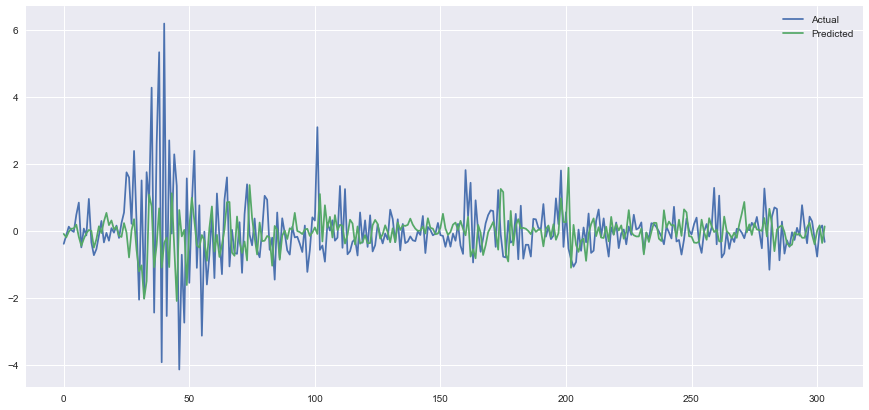

In [16]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
print('R2 out-of-sample {}'.format(r2_score(y_test, xgb_pred)))

plt.figure(figsize=(15,7))
plt.plot(y_test, label='Actual')
plt.plot(xgb_pred, label='Predicted')
plt.legend()
plt.show()

### Random Forest
And finally, let's try modelling using random forest which is also commonly used 

<ipython-input-17-9414afa13549>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, y_train)


R2 out-of-sample -0.07529582779972754


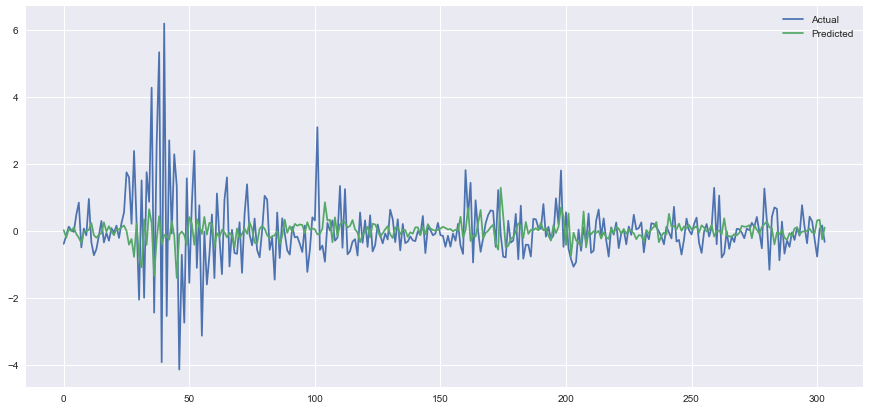

In [17]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

rf_pred = regr.predict(X_test)
print('R2 out-of-sample {}'.format(r2_score(y_test, rf_pred)))

plt.figure(figsize=(15,7))
plt.plot(y_test, label='Actual')
plt.plot(rf_pred, label='Predicted')
plt.legend()
plt.show()

In this project, we will not be using traditional score like R-squared to score the model. Instead, we will be constructing our own metrics. This is explained later in Model Evaluation section.

I'm showing R-squared for demostration purposes only.

### Issues with typical approaches

Simple Train-Test Split: 
Frequently recommended approach in ML tutorials is to split the data and to train on the first chunk of data and test out-of-sample on the second. This is not wrong, however:

* Only a fraction of data can be used to generate out-of-sample performance of the model. If we split 80/20, then you only get results for 2 of every 10 years of data

* Bias towards the most recent period. Since we're likely going to use the older data to train and newer data to test we are implicitly searching for a model which was in favor during the most recent couple of years.

We might consider train/test split with random sampling but this obviously creates other issues with peeking into the future (we mentioned look-ahead bias previously).

The better approach is to simulate models on a "walk-forward" basis, periodically re-training the model to incorporate all data available at that point in time


## Walk-Forward framework <a name="walk-forward"></a>


Once again, it is important to highlight that in financial time-series data, common technique such as train-test split (with shuffle) and cross validation have significant flows and therefore should be avoided.


Note that this time we are scaling the data on the training dataset only to avoid look ahead bias. We are only using the data that would have been available at that time. 


We will be using two approaches:
1. Expanding Window 
2. Rolling Window

### Expanding Window <a name="expanding-window"></a>

Training the models

In [35]:
recalc_dates = features_selected.resample('M').mean().index[:-1]

models = pd.Series(index=recalc_dates, dtype='object')
for date in recalc_dates:
    X_train = df_SPY.loc[:date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models.loc[date] = model
    
    print("Training on the first {} records, from {} to {}".
          format(len(y_train_scaled), y_train_scaled.index.min(), y_train_scaled.index.max()))
    print("Coefficients: {}".format((model.coef_)))


Training on the first 12 records, from 2012-01-13 00:00:00 to 2012-01-31 00:00:00
Coefficients: [[ 0.7719099  -0.55164427 -0.00863247  0.39468357 -0.5344385   0.71054012]]
Training on the first 32 records, from 2012-01-13 00:00:00 to 2012-02-29 00:00:00
Coefficients: [[ 0.27168917  0.19921058 -0.59803086  0.42309297  0.52016555  0.99011563]]
Training on the first 54 records, from 2012-01-13 00:00:00 to 2012-03-30 00:00:00
Coefficients: [[ 0.13940156 -0.17379755  0.30425779 -0.00828974  0.45748051  0.26792201]]
Training on the first 74 records, from 2012-01-13 00:00:00 to 2012-04-30 00:00:00
Coefficients: [[ 0.31531364 -0.37032517  0.0550955   0.40685412 -0.18441165 -0.02283345]]
Training on the first 96 records, from 2012-01-13 00:00:00 to 2012-05-31 00:00:00
Coefficients: [[ 0.21762379 -0.2734921   0.1259575   0.0563717  -0.06475574 -0.18726705]]
Training on the first 117 records, from 2012-01-13 00:00:00 to 2012-06-29 00:00:00
Coefficients: [[ 0.17158313 -0.1989792   0.08003581  0.29

Training on the first 1250 records, from 2012-01-13 00:00:00 to 2016-12-30 00:00:00
Coefficients: [[ 0.10106478 -0.12472424  0.07058592  0.01986701  0.06337471 -0.01550608]]
Training on the first 1270 records, from 2012-01-13 00:00:00 to 2017-01-31 00:00:00
Coefficients: [[ 0.10091142 -0.12467592  0.06928974  0.02190794  0.05899578 -0.01245262]]
Training on the first 1289 records, from 2012-01-13 00:00:00 to 2017-02-28 00:00:00
Coefficients: [[ 0.09894358 -0.12210924  0.06496966  0.02675748  0.04533339 -0.01039939]]
Training on the first 1312 records, from 2012-01-13 00:00:00 to 2017-03-31 00:00:00
Coefficients: [[ 0.09536344 -0.11639653  0.06423315  0.02598124  0.05024467 -0.01037598]]
Training on the first 1331 records, from 2012-01-13 00:00:00 to 2017-04-28 00:00:00
Coefficients: [[ 0.09850798 -0.11546533  0.06123259  0.02672942  0.04907421 -0.00867512]]
Training on the first 1353 records, from 2012-01-13 00:00:00 to 2017-05-31 00:00:00
Coefficients: [[ 0.09856209 -0.11766099  0.063

We can visualise how the model coefficients change over time using the below function

<AxesSubplot:title={'center':'Coefficients for Expanding Window Model'}>

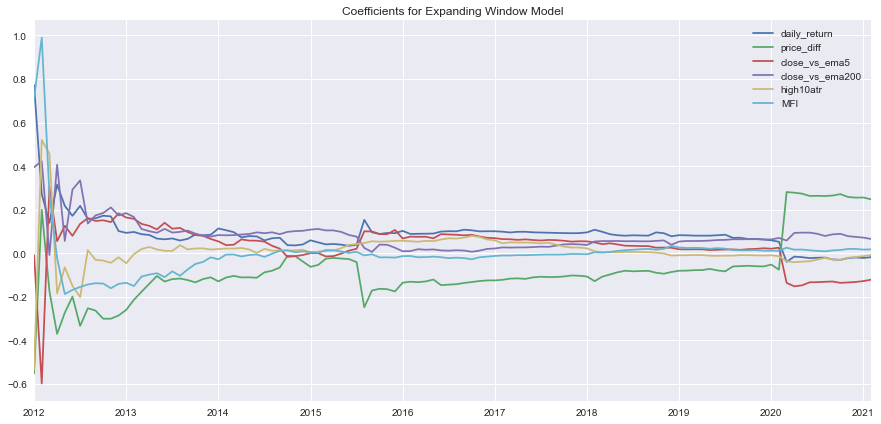

In [19]:
def build_coefs(models):
    coefs = pd.DataFrame()
    for i, model in enumerate(models):
        model_coefs = pd.Series(model.coef_[0],index=features_selected.columns.values)
        model_coefs.name = models.index[i]
        coefs = pd.concat([coefs, model_coefs],axis=1)
    return coefs.T

build_coefs(models).plot(title='Coefficients for Expanding Window Model', figsize=(15, 7))

The significance of coefficients vary as we include more data to train.


### Rolling Window <a name="rolling-window"></a>

<ipython-input-20-39ab4119a74e>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  models = pd.Series(index=recalc_dates)


 Training on the most recent 12 records
            from 2012-01-13 00:00:00 to 2012-01-31 00:00:00
 Training on the most recent 22 records
            from 2012-01-30 00:00:00 to 2012-02-29 00:00:00
 Training on the most recent 22 records
            from 2012-03-01 00:00:00 to 2012-03-30 00:00:00
 Training on the most recent 20 records
            from 2012-04-02 00:00:00 to 2012-04-30 00:00:00
 Training on the most recent 22 records
            from 2012-05-01 00:00:00 to 2012-05-31 00:00:00
 Training on the most recent 22 records
            from 2012-05-31 00:00:00 to 2012-06-29 00:00:00
 Training on the most recent 21 records
            from 2012-07-02 00:00:00 to 2012-07-31 00:00:00
 Training on the most recent 23 records
            from 2012-08-01 00:00:00 to 2012-08-31 00:00:00
 Training on the most recent 20 records
            from 2012-08-31 00:00:00 to 2012-09-28 00:00:00
 Training on the most recent 21 records
            from 2012-10-01 00:00:00 to 2012-10-31 00:00:00


            from 2019-03-01 00:00:00 to 2019-03-29 00:00:00
 Training on the most recent 21 records
            from 2019-04-01 00:00:00 to 2019-04-30 00:00:00
 Training on the most recent 22 records
            from 2019-05-01 00:00:00 to 2019-05-31 00:00:00
 Training on the most recent 21 records
            from 2019-05-31 00:00:00 to 2019-06-28 00:00:00
 Training on the most recent 22 records
            from 2019-07-01 00:00:00 to 2019-07-31 00:00:00
 Training on the most recent 22 records
            from 2019-08-01 00:00:00 to 2019-08-30 00:00:00
 Training on the most recent 20 records
            from 2019-09-03 00:00:00 to 2019-09-30 00:00:00
 Training on the most recent 23 records
            from 2019-10-01 00:00:00 to 2019-10-31 00:00:00
 Training on the most recent 21 records
            from 2019-10-31 00:00:00 to 2019-11-29 00:00:00
 Training on the most recent 21 records
            from 2019-12-02 00:00:00 to 2019-12-31 00:00:00
 Training on the most recent 21 records


<AxesSubplot:title={'center':'Coefficients for Rolling Window Model'}>

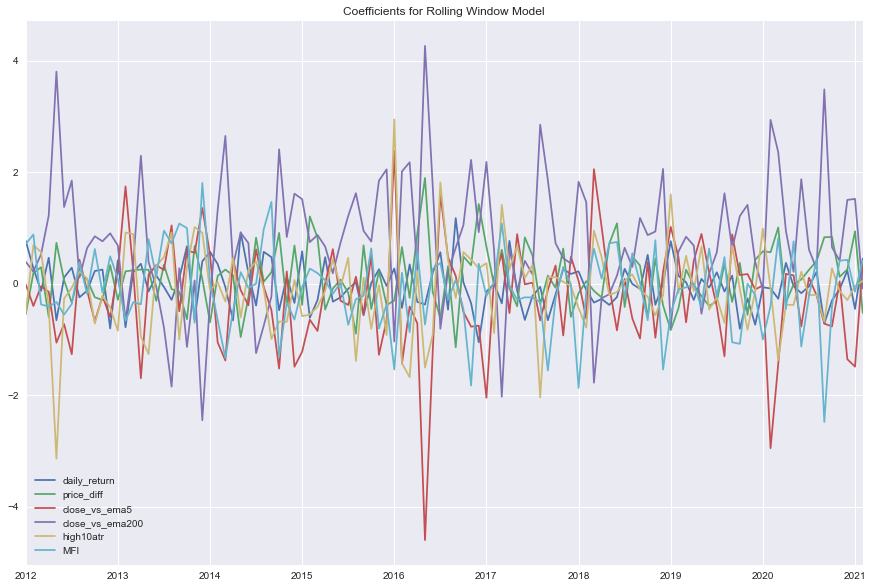

In [20]:
recalc_dates = features_selected.resample('M').mean().index.values[:-1]
models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features_selected.loc[date-pd.Timedelta('30 days'):date]
    y_train = df_SPY['target_close_1'].loc[date-pd.Timedelta('30 days'):date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models.loc[date] = model
    print(""" Training on the most recent {} records
            from {} to {}""".format(len(y_train_scaled), y_train_scaled.index.min(), y_train_scaled.index.max()))
    
build_coefs(models).plot(title='Coefficients for Rolling Window Model', figsize=(15, 10))


As we can see, the coefficients vary over time.

## Using Models <a name="using-models"></a>

Next step is to use the models trained above. 
We will create two array, `begin_dates` and `end_dates` that contain the dates on which each model is used. For example, for the first model, we'll apply this model to features beginning on the date we trained the model (`recalc_date`) until the day the next model is trained.

The `end_dates` drops the 0th element and appends to the latest date in the dataset (`df_SPY.index[-1]`)

### Linear Regression

In [21]:
models_expanding_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = df_SPY.loc[:date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models_expanding_window.loc[date] = model
    
models_rolling_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = df_SPY.loc[date-pd.Timedelta('30 days'):date, features_selected.columns]
    y_train = df_SPY['target_close_1'].loc[date-pd.Timedelta('30 days'):date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_scaled)
    models_rolling_window.loc[date] = model
    

begin_dates = models.index[:-1]
end_dates = models.index[1:-1]
end_dates = end_dates.insert(item=df_SPY.index[-1], loc=len(end_dates)) 

predictions_expanding_window = pd.Series(index=features.index, dtype='float')

for i, model in enumerate(models_expanding_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index, dtype='float')
    predictions_expanding_window.loc[X.index] = p
    
predictions_rolling_window = pd.Series(index=features.index, dtype='float')
for i, model in enumerate(models_rolling_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(np.concatenate(model.predict(X_scaled)), index=X.index, dtype='float')
    predictions_rolling_window.loc[X.index] = p

The code above looped through each of the models we had trained at various points in time and, for each, used that model to predict the period of time until the next model became available.

In [22]:
y_true = standard_scaler.fit_transform(df_SPY['target_close_1'].loc[predictions_rolling_window.dropna().index].values.reshape(-1, 1))
y_true = pd.Series(np.concatenate(y_true), index=predictions_rolling_window.dropna().index)

r2_expanding = r2_score(y_true=y_true, y_pred=predictions_expanding_window.dropna())
r2_rolling = r2_score(y_true=y_true, y_pred=predictions_rolling_window.dropna())

print("Expanding Window R2: {}".format(round(r2_expanding,3)))
print("Rolling Window R2: {}".format(round(r2_rolling,3)))

Expanding Window R2: -0.001
Rolling Window R2: -1.272


R2 out of sample (rolling): -1.441
R2 out of sample (expanding): 0.008


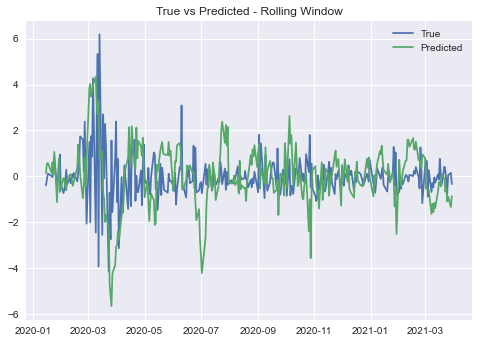

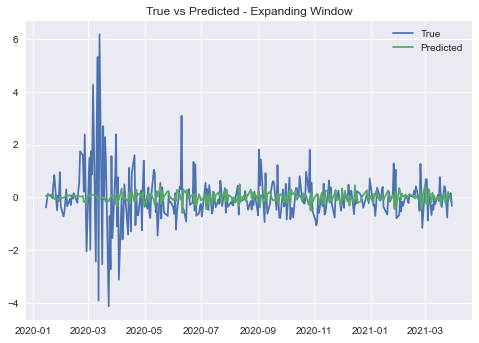

In [23]:
y_test = df_SPY['target_close_1'].iloc[split_point:]
y_test_scaled = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(np.concatenate(y_test_scaled), index=y_test.index)

common_idx = y_test.dropna().index.intersection(predictions_rolling_window.dropna().index)
r2_rolling = r2_score(y_true=y_test[common_idx], y_pred=predictions_rolling_window[common_idx])
r2_expanding = r2_score(y_true=y_test[common_idx], y_pred=predictions_expanding_window[common_idx])

print("R2 out of sample (rolling): {}".format(round(r2_rolling,3)))
print("R2 out of sample (expanding): {}".format(round(r2_expanding,3)))

plt.title('True vs Predicted - Rolling Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(predictions_rolling_window[common_idx], label='Predicted')
plt.legend()
plt.show()

plt.title('True vs Predicted - Expanding Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(predictions_expanding_window[common_idx], label='Predicted')
plt.legend()
plt.show()

Let's try XGBoost to see if it shows better performance

### XGBoost

In [24]:
xgb_models_expanding_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = features_selected.loc[:date, :]
    y_train = df_SPY['target_close_1'].loc[:date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    model = xgb.XGBRegressor()
    model.fit(X_train_scaled, y_train_scaled)
    xgb_models_expanding_window.loc[date] = model
    
xgb_models_rolling_window = pd.Series(index=recalc_dates, dtype='float')
for date in recalc_dates:
    X_train = features_selected.loc[date - pd.Timedelta('30 days'):date, :]
    y_train = df_SPY['target_close_1'].loc[date-pd.Timedelta('30 days'):date]
    
    X_train_scaled = standard_scaler.fit_transform(X_train)
    y_train_scaled = standard_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index)
    
    model = xgb.XGBRegressor()
    model.fit(X_train_scaled, y_train_scaled)
    xgb_models_rolling_window.loc[date] = model
    

begin_dates = models.index[:-1]
end_dates = models.index[1:-1]
end_dates = end_dates.insert(item=df_SPY.index[-1], loc=len(end_dates)) 

xgb_predictions_expanding_window = pd.Series(index=features.index, dtype='float')

for i, model in enumerate(xgb_models_expanding_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(model.predict(X_scaled), index=X.index, dtype='float')
    xgb_predictions_expanding_window.loc[X.index] = p
    
xgb_predictions_rolling_window = pd.Series(index=features.index, dtype='float')
for i, model in enumerate(xgb_models_rolling_window.iloc[:-1]):
    X = df_SPY.loc[begin_dates[i]:end_dates[i]][features_selected.columns]
    X_scaled = standard_scaler.fit_transform(X)
    p = pd.Series(model.predict(X_scaled), index=X.index, dtype='float')
    xgb_predictions_rolling_window.loc[X.index] = p

R2 out of sample (rolling): -0.811
R2 out of sample (expanding): -0.331


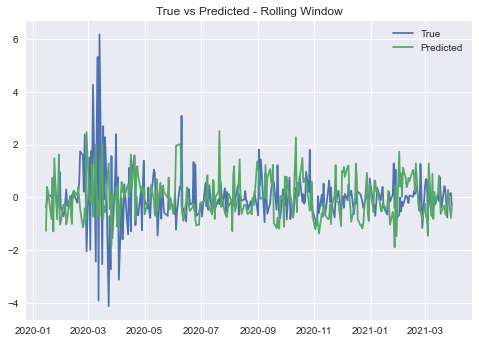

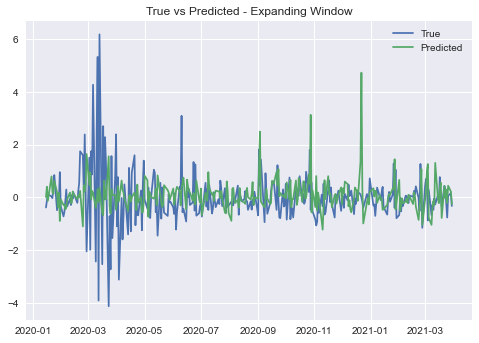

In [25]:
y_test = df_SPY['target_close_1'].iloc[split_point:]
y_test_scaled = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(np.concatenate(y_test_scaled), index=y_test.index)

common_idx = y_test.dropna().index.intersection(xgb_predictions_rolling_window.dropna().index)
r2_rolling = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_rolling_window[common_idx])
r2_expanding = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_expanding_window[common_idx])
print("R2 out of sample (rolling): {}".format(round(r2_rolling,3)))
print("R2 out of sample (expanding): {}".format(round(r2_expanding,3)))


plt.title('True vs Predicted - Rolling Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(xgb_predictions_rolling_window[common_idx], label='Predicted')
plt.legend()
plt.show()

plt.title('True vs Predicted - Expanding Window')
plt.plot(y_test[common_idx], label='True')
plt.plot(xgb_predictions_expanding_window[common_idx], label='Predicted')
plt.legend()
plt.show()

## Evaluating Model <a name="model-eval"></a>

### Tradional regression model evaluation

R-squared don't tell us much by itself. It does not provide insights about the practicality of this signal from a trading point of view.

Instead of using generic ML metric like R-squared, we will create several custom metrics that will provide a more complete picture of strength, reliability, and practicality of these models.


#### Pre-processing of data primitives

Prior to implementation of specific metrics, some data pre-processing is required. This will help us save some time later when calculating final metrics.

The following inputs will be required:

*`y_pred`: the continuous variable prediction made by our model for each timestep

*`y_true`: the continuous variable actual outcome for each timestep

We will then feed this data into a simple function below to derive the following:

*`sign_pred`: sign of prediction

*`sign_true`: sign of true outcome

*`is_correct`: 1 if sign_pred == sign_true, else 0

*`is_incorrect`: opposite

*`is_predicted`: 1 if the model has made a valid prediction, 0 if not. This is important if models only emit predictions when they have a certain level of confidence

*`result`: the profit (loss) resulting from betting one unit in the direction of the sign_pred. This is the continuous variable result of following the model

In [27]:
def construct_df(y_pred, y_true):
    """
    Constructs new dataframe that consists of the following columns:
    sign_pred: 
        sign of prediction
    sign_true: 
        sign of true outcome
    is_correct: 
        1 if sign_pred == sign_true, else 0
    is_incorrect: 
        0 if sign_pred == sign_true, else 1
    is_predicted: 
        1 if the model has made a valid prediction, 0 if not. 
        This is important if models only emit predictions when they have a certain level of confidence
    result: 
        the profit (loss) resulting from betting one unit in the direction of the sign_pred. 
        This is the continuous variable result of following the model

    """
#     indices = df_SPY['target_close_1'].iloc[split_point:].index
    y_pred = pd.Series(y_pred, name='y_pred')
    y_true = pd.Series(y_true, name='y_true')
    
    df = pd.concat([y_pred, y_true], axis=1)
    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # 1 when prediction was made and it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # 1 when prediction was made and it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true 
    return df


#### Defining new metrics


Having these intermediate pre-processed will allow us to calculate the metric more easily. These metrics include:
* *Accuracy*: Percent of predictions that were correct vs. incorrect
* *Noise*: Estimates how dramatically the model's predictions vary from one day to the next
* *Edge*: Expected value of the prediction over a sufficiently large set of draws
* *y_true_chg and y_pred_chg*: The average magnitude of change (per period) in y_true and y_pred.
* *prediction_calibration*: ratio of the magnitude of our predictions vs. magnitude of truth. Provides some indication of whether our model is properly tuned to the size of movement in addition to the direction of it.
* *capture_ratio*: Ratio of the "edge" we gain by following  predictions vs. the actual daily change. 100 would indicate that we were perfectly capturing the true movement of the target variable.


In [28]:
def calc_metrics(df):
    metrics = pd.Series()
    metrics.loc['accuracy'] = df['is_correct'].sum() / (df['is_predicted'].sum())*100
    metrics.loc['edge'] = df['result'].mean()
    metrics.loc['noise'] = df['y_pred'].diff().abs().mean()
    
    metrics.loc['y_true_chg'] = df['y_true'].abs().mean()
    metrics.loc['y_pred_chg'] = df['y_pred'].abs().mean()
    metrics.loc['prediction_calibration'] = metrics.loc['y_pred_chg']/metrics.loc['y_true_chg']
    metrics.loc['capture_ratio'] = metrics['edge']/metrics.loc['y_true_chg']*100

    return metrics    


Comparing all models

In [29]:
y_test = df_SPY['target_close_1'].iloc[split_point:]
y_test_scaled = standard_scaler.fit_transform(y_test.values.reshape(-1, 1))
y_test = pd.Series(np.concatenate(y_test_scaled), index=y_test.index)

# Combine all predictions
# Create series
lr_pred_series = pd.Series(np.concatenate(lr_pred), name='LR_simple_split', index=y_test.index)
xgb_pred_series = pd.Series(xgb_pred, name='XGB_simple_split', index=y_test.index)
xgb_rw_series = pd.Series(xgb_predictions_rolling_window[common_idx], name='XGB_rolling')
xgb_ew_series = pd.Series(xgb_predictions_expanding_window[common_idx], name='XGB_expanding')
lr_rw_series = pd.Series(predictions_rolling_window[common_idx], name='LR_rolling')
lr_ew_series = pd.Series(predictions_expanding_window[common_idx], name='LR_expanding')

# Concatenate predictions
predictions = pd.concat([lr_pred_series, xgb_pred_series, 
                         lr_rw_series, lr_ew_series,
                         xgb_rw_series, xgb_ew_series
                        ], axis=1)

common_idx = y_test.dropna().index.intersection(xgb_predictions_rolling_window.dropna().index)
r2_rolling = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_rolling_window[common_idx])
r2_expanding = r2_score(y_true=y_test[common_idx], y_pred=xgb_predictions_expanding_window[common_idx])

In [30]:
models_metrics = pd.DataFrame(index=predictions.columns, 
                              columns=['accuracy', 'edge', 'noise', 'y_true_chg', 
                                        'y_pred_chg', 'prediction_calibration', 'capture_ratio'])
for p in predictions:
    models_metrics.loc[p, :] = calc_metrics(construct_df(predictions[p], y_test))


<ipython-input-28-3baf62c8b5fa>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-28-3baf62c8b5fa>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-28-3baf62c8b5fa>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-28-3baf62c8b5fa>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics = pd.Series()
<ipython-input-28-3baf62c8b5fa>:2: DeprecationWarning: The default dtype for empty Series will be 'o

In [31]:
models_metrics

,accuracy,edge,noise,y_true_chg,y_pred_chg,prediction_calibration,capture_ratio
LR_simple_split,50.9868,0.0556519,0.0442569,0.620776,0.0530803,0.0855064,8.9649
XGB_simple_split,49.3421,-0.0195693,0.443809,0.620776,0.325315,0.524046,-3.15239
LR_rolling,55.5921,0.0959425,0.690006,0.620776,0.963333,1.55182,15.4552
LR_expanding,57.8947,0.090912,0.212185,0.620776,0.137235,0.22107,14.6449
XGB_rolling,54.6053,-0.0750915,0.724446,0.620776,0.644157,1.03766,-12.0964
XGB_expanding,53.6184,0.113117,0.514975,0.620776,0.370863,0.597418,18.2219


# Conclusion <a name="conclusion"></a>

From the above, the best method in terms of accuracy was found to be Linear Regression with expanding window approach (form of walk-forward approach) where we were able to predict direction of stock movement 58% of the time.
In terms of capture ratio (i.e. ratio of the "edge" we gain by following  predictions), XGB Boost expanding window approach showed the best performance where we saw 18% ratio, meaning that we were able to capture 18% of the true movement of the target variable.

However, these results are not sufficient enough to deploy the model for live trading. In future research section, I will explain the methods that will help improve the accuracy of the model.

As we saw, predicting the stock market is a very challenging task. 

Feature Engineering requires years of expirience in trading as well as significant time in experimentation. Due to time constraints and lack of domain knowledge, I only considered some features. However, it may be helpful to build other features based on technical indicators. Quantitative traders spend most of their time trying to extract useful features from noisy market data.



## Suggestions for Future Research <a name="suggestions"></a>

* **Feature Engineering**

I would suggest spending more time in feature engineering process to find features that better explain the target variable. Quantitative traders spend most of their time in this process.
This may significantly improve accuracy of predictioins. Unfortunately, due to time constraints, I could not afford spending more time to extract the 'alpha' from a very noisy data . In addition, domain knowledge is crucial, so those who have trading expirience are more likely to succeed.

* **LSTM**

Long-Short-Term Memory Recurrent Neural Network belongs to the family of deep learning algorithms. It is a recurrent network because of the feedback connections in its architecture. It has an advantage over traditional neural networks due to its capability to process the entire sequence of data. Its architecture comprises the cell, input gate, output gate and forget gate.

LSTM is a very popular appoach used in time-series predictions. It has shown good performance on stock market predictions which outperformed simple models like linear regression.

However, in this project, I chose simple models because they are easy to interpret and fine-tune.

* **Sentiment Analysis**

In this project, I only used historical prices to predict future returns. However, as we know, the stock market is one of the most sensitive fields, where sentiments of the people can change the trend of the entire market. 
Therefore, AI companies are now using sentiment analysis in the stock market to predict the market trend or movement of a particular stock. Sentiment analysis is the process of analysing the sentiments of people through platforms like social media (commonly used Twitter), where people express their opinions. The sentiment analysis uses Natural Language Processing  to divide the language units into three categories: Negative, Positive and Neutral.

Many research papers have shown that using the combination of historical prices and sentiment analysis has improved the accuracy of predictions.



# References <a name="references"></a>

https://www.investopedia.com/terms/r/rsi.asp

https://www.investopedia.com/terms/m/macd.asp

https://altfins.com/knowledge-base/macd-line-and-macd-signal-line/

https://www.investopedia.com/terms/s/stochasticoscillator.asp

https://www.investopedia.com/terms/a/accumulationdistribution.asp

https://www.investopedia.com/terms/a/atr.asp

https://www.investopedia.com/articles/active-trading/072115/understand-vortex-indicator-trading-strategies.asp

https://www.investopedia.com/terms/e/easeofmovement.asp

https://www.investopedia.com/terms/c/commoditychannelindex.asp

https://www.investopedia.com/terms/o/onbalancevolume.asp

https://www.investopedia.com/terms/m/mfi.asp

https://www.investopedia.com/terms/l/lookaheadbias.asp

